In [1]:
# %pip install  tqdm iprogress ipywidgets numpy pandas -U
# %pip install torch matplotlib dtaidistance -U
# %pip install scikit-learn
# %pip install numpy --pre 
# %pip install torch torchvision torchaudio --force-reinstall --index-url https://download.pytorch.org/whl/nightly/cu118
# %pip install tensorflow tensorrt -U
# %pip install --upgrade intel-extension-for-tensorflow[cpu]

In [2]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers as L
import numpy as np
import matplotlib.pyplot as plt
import json
from json import JSONEncoder
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy import signal, io
from dtaidistance import dtw, similarity
import librosa


In [3]:
# set random seed for reproducibility
# np.random.seed(1001)
# torch.manual_seed(0)

In [4]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
device = 'cuda' if tf.test.is_gpu_available() else 'cpu'
print('Using {} device'.format(device))


Num GPUs Available:  1
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Using cuda device


2024-03-26 22:08:53.453839: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-03-26 22:08:53.453859: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-03-26 22:08:53.453867: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-03-26 22:08:53.453883: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 22:08:53.453894: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
def gold_transform(x):
    return np.tanh(x*3)

(6879600,)
Maximum value of x:  0.9937685 Tanh of maximum value of x:  0.7589646


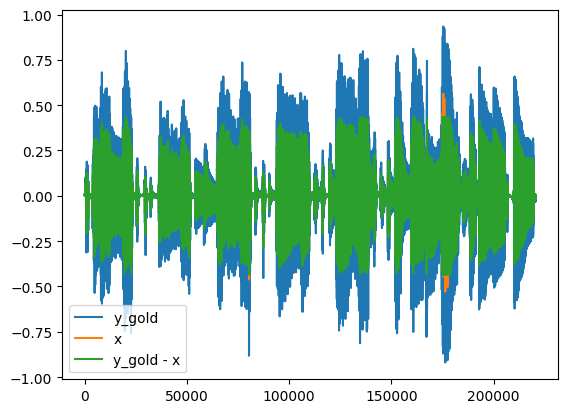

In [6]:
# Let's make an input and gold output
XLEN = 100
# x = np.sin(np.arange(0, XLEN, 0.1)) + np.random.normal(0, 0.1, XLEN*10)
audio_x_file = '../audio/Ben Direct Guitar.wav'
x, sample_rate = librosa.load(audio_x_file)

# gold output is  just input amplified by 2
y_gold = gold_transform(x)

sample_start = sample_rate*30
sample_end = sample_start + sample_rate*10
print(y_gold.shape)
print("Maximum value of x: ", np.max(x), "Tanh of maximum value of x: ", np.tanh(np.max(x)))    
plt.plot(y_gold[sample_start:sample_end])
plt.plot(x[sample_start:sample_end])
plt.plot(y_gold[sample_start:sample_end] - x[sample_start:sample_end])
plt.legend(['y_gold','x','y_gold - x'])
plt.show()


In [7]:
hidden_size = 24
model = keras.Sequential()
model.add(L.InputLayer(shape=(None, 1)))
model.add(L.LSTM (hidden_size, return_sequences=True))
model.add(L.Dense(1))
model.summary()

2024-03-26 22:08:58.639433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-26 22:08:58.639499: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, None, 24)       │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, None, 1)        │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

2024-03-26 22:08:59.191153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


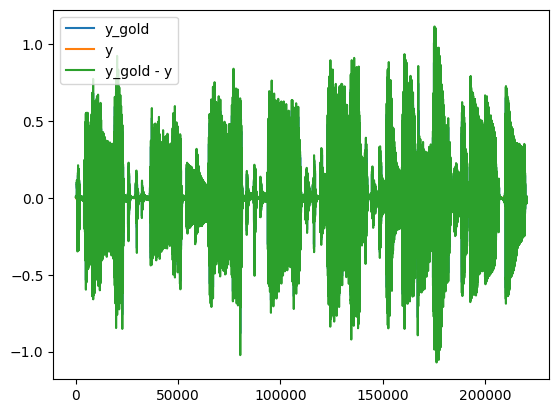

In [8]:

y_sample = model.predict(x[sample_start:sample_end].reshape((1, -1, 1)), verbose=1).flatten()
plt.plot(y_gold[sample_start:sample_end])
plt.plot(y_sample)
plt.plot(y_gold[sample_start:sample_end] - y_sample)
plt.legend(['y_gold','y', 'y_gold - y'])


In [9]:
# Let's train!
NUM_EPOCHS = 100
x_tensor = x.reshape(-1, 1, 1)
y_gold_tensor = y_gold.reshape(-1, 1, 1)
batch_size = 44100

class PredictionCallback(tf.keras.callbacks.Callback):
    def __init__(self, x_test):
        super(PredictionCallback, self).__init__()
        self.x_test = x_test
        self.predictions = []

    def on_epoch_end(self, epoch, logs=None):
        y_pred = self.model.predict(self.x_test, verbose=0).flatten()
        self.predictions.append(y_pred)

predictions_callback = PredictionCallback(x_test=x_tensor)

early_stop_callback = keras.callbacks.EarlyStopping(
    monitor="loss", min_delta=0, patience=3, verbose=True, mode="auto",
    baseline=None, restore_best_weights=True, start_from_epoch=0)


model.compile(optimizer='adam', loss='mse')
history = model.fit(x_tensor, y_gold_tensor, epochs=NUM_EPOCHS, 
                    batch_size=batch_size, callbacks=[early_stop_callback, predictions_callback ], verbose=True)


Epoch 1/100


: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


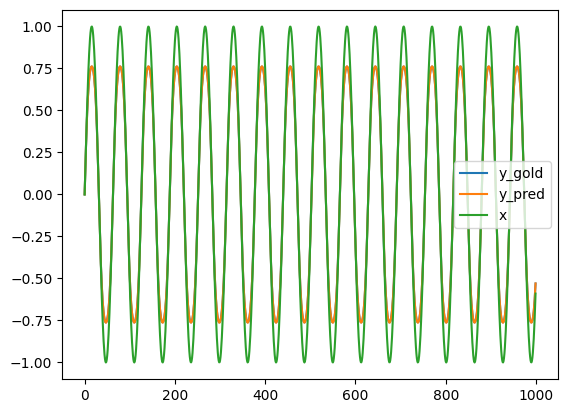

In [43]:
y_sample_trained = model.predict(x[sample_start:sample_end].reshape((1, -1, 1)), verbose=1).flatten()
plt.plot(y_gold[sample_start:sample_end])
plt.plot(y_sample_trained)
plt.plot(y_gold[sample_start:sample_end] - y_sample_trained)
plt.legend(['y_gold','y', 'y_gold - y'])

In [44]:
import model_utils
import importlib
importlib.reload(model_utils)
save = True

if save == True:
    model_utils.save_model(model, f'lstm_tanh_{hidden_size}.json')


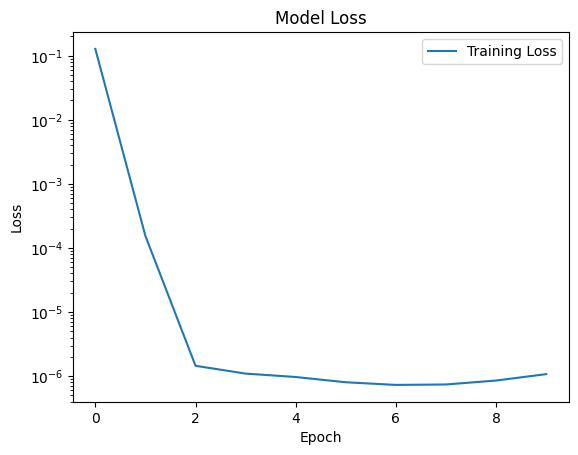

In [45]:
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Model Loss')
plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

(10, 1000)


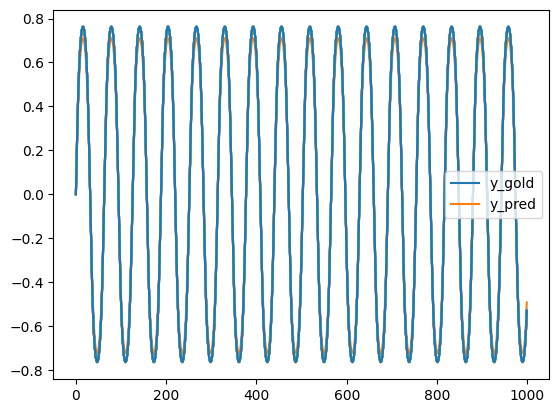

In [46]:
# plot the predictions versus gold
y_pred_1d = [p for p in predictions_callback.predictions]

print(np.shape(y_pred_1d))

plt.plot(y_gold)
for y in y_pred_1d:
    plt.plot(y)
plt.legend(['y_gold', 'y_pred'])
plt.show()

(10, 1000)


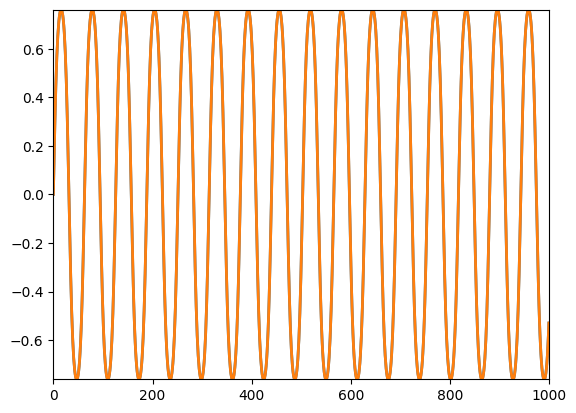

In [47]:
# %matplotlib 
print(np.shape(y_pred_1d)) 
y_range = range(len(y_gold))
fig, ax = plt.subplots()
ax.set_xlim(0, len(y_gold))
ax.set_ylim(min(y_gold), max(y_gold ))

# Plot y_gold
y_gold_line, = ax.plot([], [], label='y_gold', lw=2)
y_gold_line.set_data(y_range, y_gold)

# Initialize an empty line for the predictions
y_pred_line, = ax.plot([], [], label='y_pred', lw=2)

def init():
    y_pred_line.set_data([], [])
    return y_gold_line, y_pred_line

def update(frame):
    # Update the data for the y_pred_line
    y_pred_line.set_data(y_range, y_pred_1d[frame])
    return y_gold_line, y_pred_line

ani = FuncAnimation(fig, update, frames=range(len(y_pred_1d)), 
                    init_func=init, blit=True, repeat=False, interval=100)
HTML(ani.to_html5_video())

# ax.legend()
# plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━

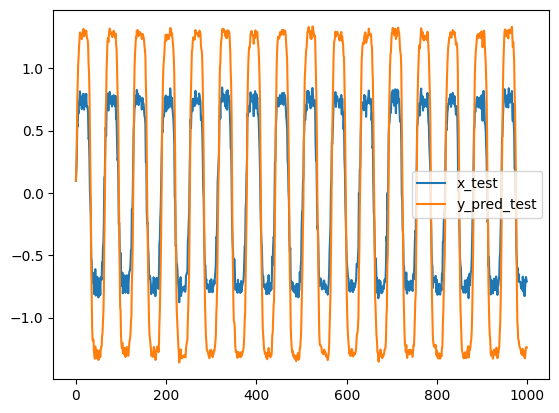

In [48]:
# let's make a input of a random waveform and run N times
NUM_TESTS = 100
y_pred_test_list = []
for i in tqdm(range(NUM_TESTS)):
    # x_test = np.random.rand(len(x))
    x_test = np.sin(x*np.random.normal()) + np.random.normal(scale=0.1, size=len(x))
    y_gold_test = gold_transform(x_test)
    y_pred_test = model.predict(x_test.reshape(1,-1,1)).flatten()
    y_pred_test_list.append(y_pred_test)

fig, ax = plt.subplots()
# plt.plot(x_test)
plt.plot(y_gold_test)
plt.plot(y_pred_test)
plt.legend(['x_test', 'y_pred_test'])
plt.show()


In [49]:
# a whole bunch of stats
differences = [(y_gold_test) - y_pred_test for y_pred_test in y_pred_test_list]
abs_differences = [np.abs(d) for d in differences]
max_differences = [np.max(d) for d in differences]
min_differences = [np.max(d) for d in differences]
mean_differences = [np.mean(d) for d in differences]
variances = [np.var(d) for d in differences]
s_divs = [np.std(d) for d in differences]
correlations = [np.corrcoef(y_gold_test, y_pred_test)[0, 1] for y_pred_test in y_pred_test_list]
mse_values = [np.mean((y_gold_test - y_pred_test)**2) for y_pred_test in y_pred_test_list]
rmse_values = [np.sqrt(mse) for mse in mse_values]

In [51]:
# print stats
print(f'max difference: {np.max(max_differences)}')
print(f'min difference: {np.min(min_differences)}')
print(f'mean difference: {np.mean(mean_differences)}')
print(f'variance: {np.mean(variances)}')
print(f'standard deviation: {np.mean(s_divs)}')
print(f'correlation: {np.mean(correlations)}')
print(f'mse: {np.mean(mse_values)}')
print(f'rmse: {np.mean(rmse_values)}')

max difference: 2.1943887926834225
min difference: 0.5577080774607494
mean difference: 0.03947824870474713
variance: 1.0694105955778161
standard deviation: 0.8585875442039899
correlation: 0.012933770644010046
mse: 1.0714086586468077
rmse: 0.8605991699963169


(101, 101)


[]

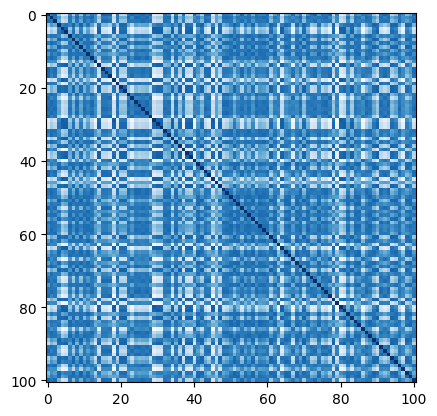

In [ ]:
# Mucking around with simlarity using DTW
s = np.vstack([np.array(y_gold), np.array([y for y in y_pred_test_list[:100]])])
sim = similarity.distance_to_similarity(dtw.distance_matrix_fast(s))
print(sim.shape)
# sim = similarity.squash(s)
plt.imshow(sim, cmap='Blues', interpolation='nearest')
plt.plot()


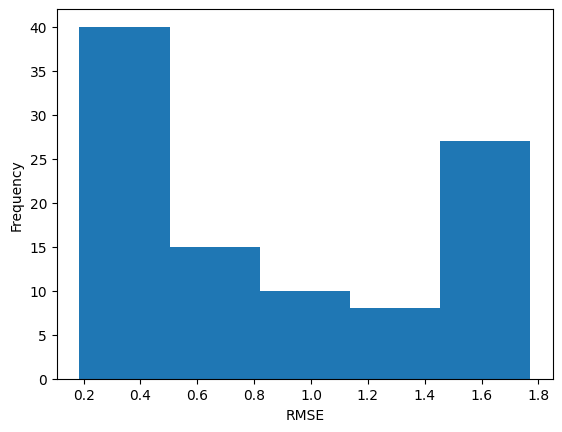

In [52]:
plt.hist(rmse_values, bins=5)
plt.xlabel('RMSE')
plt.ylabel('Frequency')
plt.show()

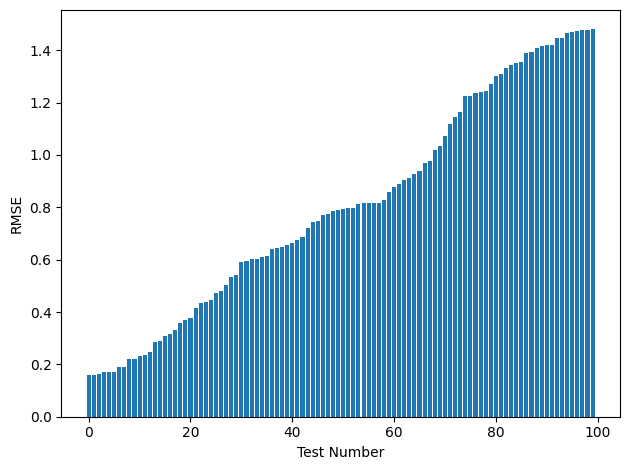

In [37]:
plt.bar(range(NUM_TESTS), sorted(rmse_values))
# plt.xticks(range(NUM_TESTS), labels=[f'{i+1}' for i in range(NUM_TESTS)])  # Labeling x-axis with test numbers
plt.xlabel('Test Number')  # x-axis label
plt.ylabel('RMSE')  # y-axis label
plt.tight_layout()
plt.show()

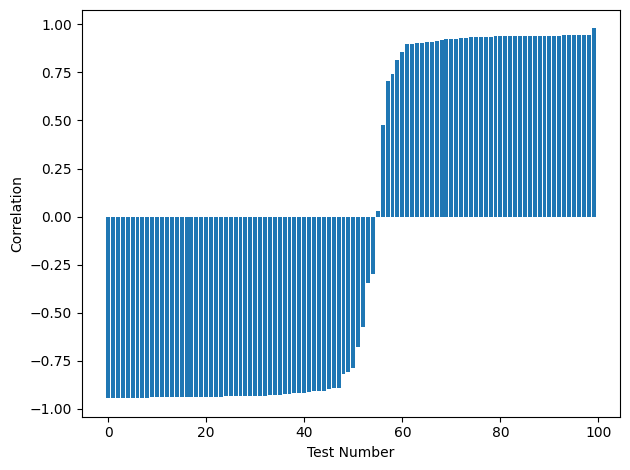

In [23]:
plt.bar(range(NUM_TESTS), sorted(correlations))
# plt.xticks(range(NUM_TESTS), labels=[f'{i+1}' for i in range(NUM_TESTS)])  # Labeling x-axis with test numbers
plt.xlabel('Test Number')  # x-axis label
plt.ylabel('Correlation')
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Max Difference: 0.5461398696547548
Min Difference: -0.8181052063959046
Mean Difference: 0.049558637255082125
Variance: 0.1763671824286679
Standard Deviation: 0.4199609296454468


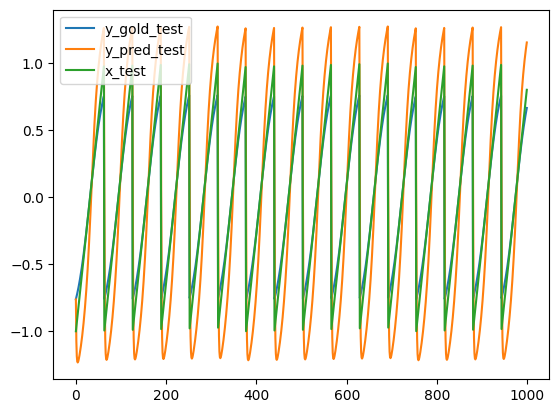

In [53]:
# how about a sawtooth?
x_test = signal.sawtooth(np.arange(0, 100, 0.1))
y_gold_test = gold_transform(x_test)

y_pred_test = model.predict(x_test.reshape(1,-1,1)).flatten()
fig, ax = plt.subplots()
# plt.plot(x_test)
plt.plot(y_gold_test)
plt.plot(y_pred_test)
plt.plot(x_test)
plt.legend(['y_gold_test', 'y_pred_test', 'x_test'])
differences = (y_gold_test) - y_pred_test
print(f'Max Difference: {np.max(differences)}')
print(f'Min Difference: {np.min(differences)}')
print(f'Mean Difference: {np.mean(differences)}')
print(f'Variance: {np.var(differences)}')
print(f'Standard Deviation: {np.std(differences)}')

plt.show()